In [68]:
#######################################################################
## Web-crawler 1.0
## Created by:  Coenraad F. Mulder
## Date:        01-12-2021
## Purpose:     Webscrape Twitter feed for specific hashtags, 
##              then supplement
##              with additional information from the Twitter API
#######################################################################
# Libraries
#######################################################################
import requests                         # For getting URLS from the Web
import pandas as pd                     # DataFrame functionality
import snscrape.modules.twitter as sntwitter  # Scraper for Twitter feed
from datetime import datetime, timedelta      # Date and time manipulation
import nltk                                   # NLP toolkit
from nltk.tokenize import word_tokenize       # Word tokenizers
from nltk.corpus import stopwords             # Stop Words to remove
from nltk.stem import WordNetLemmatizer       # Lemmatizer functions for NLP
import re, string, unicodedata                # Regular expression operations
import matplotlib.pyplot as plt               # Graphing and plotting data
import contractions
import inflect
from wordcloud import WordCloud               # Keyword visualisations
import ast                                    # Safe evaluation of string lists
import collections                            # Frequency distributions

# Webcrawler | Task 2
The primary focus of this assignment is the Twitter platform (https://www.twitter.com), specifically focusing on the hype that is created on this platform when a new variant or strain of Coronavirus is identified. The latest variant, Omicron, has been identified less than two weeks ago, which has caused a surge in social media commentary from both experts and amateurs alike. This begs the question: what are the issues that people are discussing around Omicron, and is the prevalent sentiment around it positive or negative? Is this variant as infectuous and deadly as its predecessor, or is its' impact just amplified through unsolicited social commentary fueled by fear and uncertainty? To investigate these issues, this web crawler was created to scrape a specified number of Tweets, spanning a specified number of days, and covering all English language Tweets during this period, around a specified keyword. For instance, this implementation uses the Twitter Web Crawler to scrape Twitter for all Tweets between the 5th of December 2021 and the 14 days leading up to it, limiting the Tweets to 1000 Tweets, and using the keyword search term 'Omicron' (refer to the Hyper-parameters for the Scraper code segment below).

In [69]:
#######################################################################
# Hyper-parameters for the Scraper
#######################################################################
date_to = '2021-12-05'
number_of_days = 14
tweet_limit = 1000
search_term = 'omicron'

lemmatizer = WordNetLemmatizer()

This assignment uses the 'snscrape' library, with the __TwitterSearchScraper__ from the 'sntwitter' component. The snscrape library is a Python-based scraper for social networking services (JustAnotherArchivist, 2021). Twitter provides a number of Content Services, providing access to Users, User profiles, Hashtags etc. This web crawler implements the 'Searches' service of Twitter by performing a queried search on Twitter (e.g. https://www.twitter.com/search?q=omicron...) using the TwitterSearchScraper. 

The TwitterSearchScraper returns a number of properties for each Tweet, however, only the following values have been extracted (of which the actual __Tweeted Text__ is the main focus of the NLP tasks):
* Date of Tweet
* Tweet Id
* Tweeted Text
* Username of user that tweeted 

Tweets on the Twitter platform are public by default; therefore anyone can view and interact with public Tweets, whether or not they have a Twitter account. The web crawler uses the Twitter search function for all public Tweets, and according to the Terms and Conditions of Twitter, any content that is submitted, posted or displayed on any of the Twitter Services is made available to the rest of the world (Twitter, 2021). The focal point of this web crawler is the actual Tweets that users post on the Twitter platform; therefore, no further metadata supplementation was required. All Tweets are processed in a similar manner, regardless of the falsehood of the Tweet (no assumptions have been made with regards to the truth of any Tweeted statements, and does not represent the beliefs of the developer in any shape or form). 

## Demonstration of the application of the Web Crawler
To execute the Web Crawler, the following code segment (with corresponding output from the Web Crawler) was executed (refer to the Python Code section for the actual implementation).

![Web Crawler Output](images/run_the_webcrawler.png)

## Methodology of processing, cleaning and storing harvested data for NLP tasking
This web crawler processes the harvested data one Tweet at a time, extracting the Tweeted Text, and performing the following cleaning tasks on the Tweeted Text:
1. Remove URLs from the text (most Tweets contain a reference to a URL of some sort)
2. Replace common English contractions with the expanded version, such as replacing "you're" with "you are". The __contractions__ python package is used to perform the contractions.
3. The text is tokenized using the __nltk.word_tokenize__ function.
4. The tokenized text is now normalised through a number of steps:
    1. Remove all non-ASCII characters
    2. Convert all words to lowercase
    3. Remove punctuation marks
    4. Replace numbers with word equivalents
    5. Remove stopwords - the English stop words were extended to also remove the search term for the web crawler, as this search term will appear in every Tweet harvested.
    6. Lemmatize the words - the decision was made to only use lemmatization on the words and not Stemming as well, since it has been proven that lemmatization is more effective at word reduction by considering the language's full vocabulary, rather than just the word itself (Korenius et al., 2004).
    
The harvested data, including the normalised tokenized words are extracted and saved into a Microsoft Excel spreadsheet (called __tweets.xlsx__), which is created in the same directory as where the Twitter Web Crawler is deployed. The decision was made to preserve the data in Excel format, rather than CSV, as the original Tweeted text may contain commas, which will break the CSV format. The rest of the NLP tasks consume the __tweets.xlsx__ Excel file for further processing.

## Summary and visualisation of the harvested data

### Import the harvested data into a dataframe

In [44]:
# Import the harvested data from Excel into a dataframe
tweets_df = pd.read_excel("tweets.xlsx")
tweets_df.head()

,Date,Tweet Id,Tweet Text,Username,Tweet Length,words
0,2021-12-04,1467282552117501952,WHO says no deaths reported from Omicron yet a...,HappinessPatrol,145,"['say', 'death', 'reported', 'yet', 'covid', '..."
1,2021-12-04,1467282552075529984,Will the Omicron Travel Restrictions Work? - T...,ZZsheyn,83,"['travel', 'restriction', 'work', 'new', 'york..."
2,2021-12-04,1467282547906339072,"@VaccineJo Omicron is simply a fitness test, a...",stevenjfrisch,148,"['vaccinejo', 'simply', 'fitness', 'test', 'pr..."
3,2021-12-04,1467282539433926912,@johnpavlovitz SWEET JESUS JOHN! WHY OH WHY! J...,butterflybees11,176,"['johnpavlovitz', 'sweet', 'jesus', 'john', 'o..."
4,2021-12-04,1467282530949033984,@Channel4News @krishgm I'm done humouring Fasc...,Anne_Other1,206,"['channel4news', 'krishgm', 'done', 'humouring..."


### Create a word cloud from the tweeted words

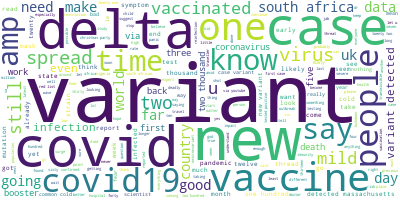

In [62]:
# Create a long string with all the words
long_string = ','.join(tweets_df['words'].apply(
    lambda x: ','.join(ast.literal_eval(x))))
tweeted_words = ' '.join(tweets_df['words'].apply(
    lambda x: ' '.join(ast.literal_eval(x))))

# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white", max_words=5000, 
    contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Plot twenty words

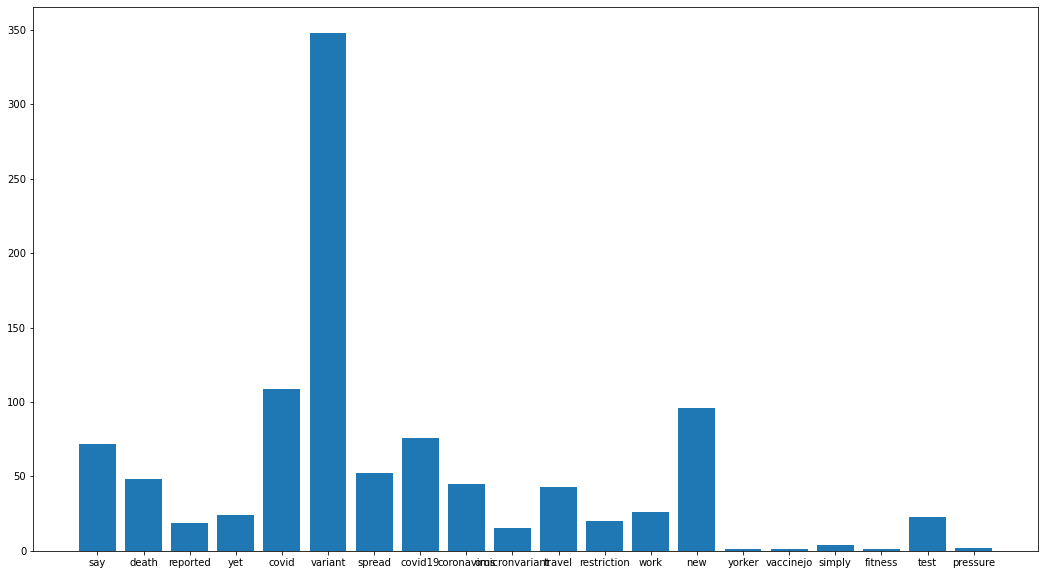

In [60]:
from nltk.tokenize.toktok import ToktokTokenizer

#create the instance of ToktokTokenizer()
tokenizer = ToktokTokenizer()
#tokenize tweeted words
word_tokens = tokenizer.tokenize(tweeted_words)

word_counts = collections.Counter(word_tokens)

plt.figure(figsize=(18, 10))
plt.bar(list(word_counts.keys())[:20], list(word_counts.values())[:20])
plt.show()

### Plot word frequency distribution for top 100 words

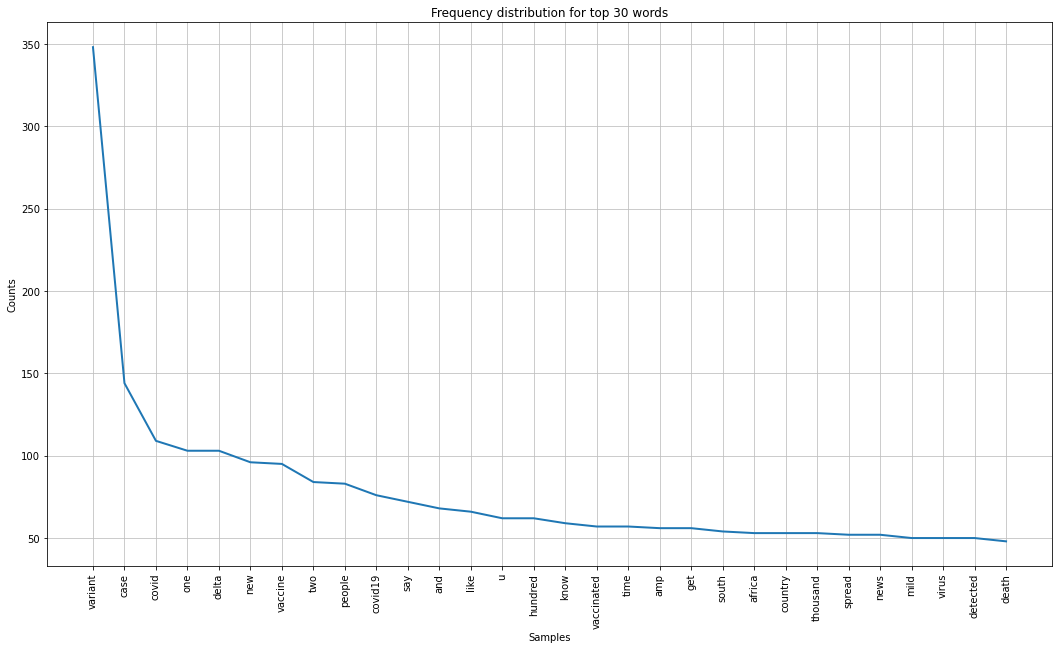

In [61]:
plt.figure(figsize=(18, 10))
fd = nltk.FreqDist(word_counts)
fd.plot(30, title='Frequency distribution for top 30 words')
plt.show()

## References
JustAnotherArchivist. (2021). snscrape. https://github.com/JustAnotherArchivist/snscrape

Korenius, T., Laurikkala, J., Järvelin, K., & Juhola, M. (2004). Stemming and lemmatization in the clustering of Finnish text documents. https://doi.org/10.1145/1031171.1031285 

Twitter. (2021). Twitter Terms of Service. https://twitter.com/en/tos

## Python Code
### Helper functions for text preprocessing

In [70]:
stop_words = stopwords.words('english')
# Remove the search term from the Tweets, as the scrape uses the keyword for 
# searching, and every Tweet will contain the search_term
stop_words.extend([search_term])

# Language functions to perform text preprocessing
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode(
            'ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with 
    textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def lemmatize_words(words):
    """Lemmatize all words in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)
    return lemmas

def normalise(words):
    # Remove all non-ASCII characters
    words = remove_non_ascii(words)
    # Convert all words to lowercase
    words = to_lowercase(words)
    # Remove punctuation marks
    words = remove_punctuation(words)
    # Replace numbers with word equivalents
    words = replace_numbers(words)
    # Remove stopwords
    words = remove_stopwords(words)
    # Lemmatize the words
    words = lemmatize_words(words)
    return words

def preprocess(text):
    """Perform preprocessing on the provided text"""
    # Remove URLs
    text = remove_URL(text)
    
    # English contractions
    text = replace_contractions(text)
    
    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Normalise
    return normalise(words)

### Web crawler class and methods

In [71]:
#######################################################################
# Twitter Web Crawler class
#######################################################################
### INPUT
#----------------------------------------------------------------------
#   search_term    : Term to search Twitter with
#   search_limit   : Maximum number of tweets to return  
#   search_to_date : End date for date range in format yyyy-mm-dd 
#   number_of_days : Number of days to go back in history  
#
### OUTPUT
#----------------------------------------------------------------------
#   tweets.xlsx    : Excel spreadsheet containing:
#                       - Date
#                       - Tweet Id
#                       - Tweet Text
#                       - Username of Tweeter
#                       - Tweet Length
#######################################################################
dt_except = "Invalid search_to_date! Value must be in format yyyy-mm-dd."
class TwitterWebCrawler():
    ###################################################################
    # CONSTRUCTOR                                                     
    ###################################################################
    def __init__(
        self, search_term, search_limit, search_to_date, number_of_days):
        dt_to = self.validate_date(input_date = search_to_date)
        
        if(dt_to == None):
            raise Exception(dt_except)

        dt_from = self.calc_from_date(dt_to, number_of_days)
        date_from = dt_from.strftime("%Y-%m-%d")
        date_to = dt_to.strftime("%Y-%m-%d")

        # Set the search terms for twitter specifying from and to dates
        # Only return English Tweets
        query = search_term + ' since:' + date_from + ' until:' 
        query = query + date_to + ' lang:en' 
        self.search_term = query
        self.search_limit = search_limit
        self.tweets_df = pd.DataFrame(
            columns=[
                'Date', 'Tweet Id', 
                'Tweet Text', 'Username', 
                'Tweet Length'])
            
    def validate_date(self, input_date):
        try:
            # Attempt to construct a date from the input_date
            # Date must be in format 'yyyy-mm-dd'
            return datetime.strptime(input_date, "%Y-%m-%d")
        except ValueError:
            return None

    def calc_from_date(self, input_datetime, number_of_days):
        try:
            return input_datetime - timedelta(days=number_of_days)
        except ValueError:
            return None
        except TypeError:
            return None

    def normalise_tweets(self):
        try:
            print(datetime.now(), 
                "Preprocessing: Normalise the Tweeted Text...")
            self.tweets_df['words'] = self.tweets_df['Tweet Text'].apply(
                lambda x: preprocess(x))
            print(datetime.now(), "Preprocessing completed successfully")
        except Exception as e:
            raise Exception(e)

    def save_data_to_file(self):
        try:
            # Dates are implicitly stored as DateTime with Timezone 
            # in pandas dataframe - Remove timezone before storing to Excel
            self.tweets_df['Date'] = self.tweets_df['Date'].apply(
                lambda a: pd.to_datetime(a).date())

            # Save the dataframe content to an Excel file 
            # as it is possible for the tweets to contain commas, 
            # which will break CSV format
            self.tweets_df.to_excel('tweets.xlsx', index = None, header=True)
            print(datetime.now(), 
                "Tweet results successfully saved to the file 'tweets.xlsx'")
        except Exception as e:
            raise Exception(e)
    
    ###################################################################
    # Main execution thread for Twitter Web Crawler
    ###################################################################
    def run(self):
        try:
            print(datetime.now(), "Extracting tweets using search term: ", 
                self.search_term)

            # Using TwitterSearchScraper to scrape data and append tweets to 
            # list
            twitter_items = sntwitter.TwitterSearchScraper(
                self.search_term).get_items()

            print(datetime.now(), "Extracting tweets...")
            for idx,tweet in enumerate(twitter_items):
                # Only retrieve records up to search_limit of tweets
                if idx >= self.search_limit:
                    break

                tweet_length = len(str(tweet.content))

                # Add the extracted Tweet to the Tweets dataframe 
                self.tweets_df.loc[len(self.tweets_df)] = [
                    tweet.date, tweet.id, tweet.content, 
                    tweet.user.username, tweet_length]

            print(datetime.now(), "Extraction completed successfully")
            
        except Exception as e:
            raise Exception(e)

### Execute the web crawler

In [72]:
if __name__ == '__main__':
    try:
        mycrawler = TwitterWebCrawler(
            search_term = search_term, 
            search_limit = tweet_limit, 
            search_to_date = date_to, 
            number_of_days = number_of_days)
        mycrawler.run()
        mycrawler.normalise_tweets()
        mycrawler.save_data_to_file()
    except Exception as e:
        print(datetime.now(), "ERROR OCCURRED!", str(e))

2021-12-08 10:42:58.770647 Extracting tweets using search term:  omicron since:2021-11-21 until:2021-12-05 lang:en
2021-12-08 10:42:58.771010 Extracting tweets...
2021-12-08 10:43:33.039535 Extraction completed successfully
2021-12-08 10:43:33.041437 Preprocessing: Normalise the Tweeted Text...
2021-12-08 10:43:33.344213 Preprocessing completed successfully
2021-12-08 10:43:33.467853 Tweet results successfully saved to the file 'tweets.xlsx'
